# 1. libraries

In [47]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split,KFold
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,BaggingRegressor,VotingRegressor,StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor,XGBRegressor
from catboost import CatBoostRegressor
from category_encoders import CountEncoder
sns.set()


## importing data

In [2]:
data =  pd.read_csv('Train.csv')
test_data =  pd.read_csv('Test.csv')
sub = pd.read_csv('SampleSubmission.csv')

In [3]:
data.shape

(7205, 9)

## dropping columns with missing target

In [4]:
data = data[data['Amount (Million Naira)'].notnull()]

target_col = data['Amount (Million Naira)']

## data shape

In [5]:
data.shape,test_data.shape

((7188, 9), (2061, 8))

## data view

In [6]:
data.head()

,VehicleID,Location,Maker,Model,Year,Colour,Amount (Million Naira),Type,Distance
0,VHL12546,Abuja,Honda,Accord Coupe EX V-6,"2,011",Silver,2.2,Nigerian Used,NaN
1,VHL18827,Ibadan,Hyundai,Sonata,"2,012",Silver,3.5,Nigerian Used,"125,000"
2,VHL19499,Lagos,Lexus,RX 350,"2,010",Red,9.2,Foreign Used,"110,852"
3,VHL17991,Abuja,Mercedes-Benz,GLE-Class,"2,017",Blue,22.8,Foreign Used,"30,000"
4,VHL12170,Ibadan,Toyota,Highlander,"2,002",Red,2.6,Nigerian Used,"125,206"


In [7]:
test_data.head()

,VehicleID,Location,Maker,Model,Year,Colour,Type,Distance
0,VHL18518,Abuja,BMW,323i,"2,008",White,Foreign Used,30524.0
1,VHL17149,Lagos,Toyota,Camry,"2,013",White,Foreign Used,NaN
2,VHL10927,Lagos,Toyota,Highlander Limited V6,"2,005",Gold,Foreign Used,NaN
3,VHL12909,Lagos,Toyota,Camry,"2,011",Gray,Foreign Used,166839.0
4,VHL12348,Lagos,Lexus,ES 350 FWD,"2,013",Red,Foreign Used,88862.0


## target view

<AxesSubplot:>

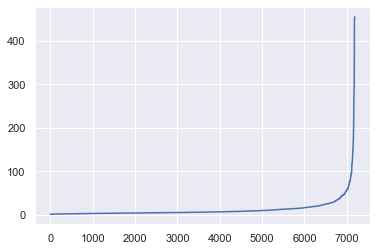

In [8]:
data.sort_values('Amount (Million Naira)')['Amount (Million Naira)'].reset_index(drop =True).plot()

In [9]:
data.describe()

,Amount (Million Naira)
count,7188.000000
mean,11.847999
std,25.318922
min,0.450000
25%,3.500000
50%,5.650000
75%,11.662500
max,456.000000


## missing values

In [10]:
data.isnull().sum()

VehicleID                    0
Location                     0
Maker                        0
Model                        0
Year                        21
Colour                       0
Amount (Million Naira)       0
Type                       196
Distance                  2352
dtype: int64

In [11]:
test_data.isnull().sum()

VehicleID      0
Location       0
Maker          0
Model          0
Year           2
Colour         0
Type          54
Distance     676
dtype: int64

### the data is mostly categorical

### let's check the unique values in each columns

#### train

In [12]:
for column in data.columns:
    print(column,":::::: ",data[column].nunique())

VehicleID ::::::  5129
Location ::::::  3
Maker ::::::  55
Model ::::::  1221
Year ::::::  33
Colour ::::::  21
Amount (Million Naira) ::::::  742
Type ::::::  3
Distance ::::::  3140


#### test

In [13]:
for column in test_data.columns:
    print(column,":::::: ",test_data[column].nunique())

VehicleID ::::::  1873
Location ::::::  3
Maker ::::::  40
Model ::::::  587
Year ::::::  29
Colour ::::::  18
Type ::::::  3
Distance ::::::  1020


#### from the unique values of the VehicleID colums, there's most likely duplicates

### distribution of cars over years

<AxesSubplot:ylabel='index'>

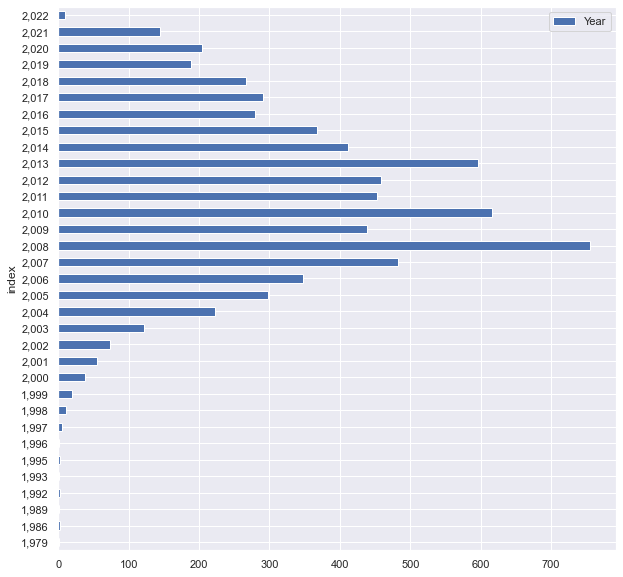

In [14]:
data.Year.value_counts().reset_index().sort_values('index').set_index('index').plot(kind = 'barh',figsize=(10,10))

<AxesSubplot:ylabel='index'>

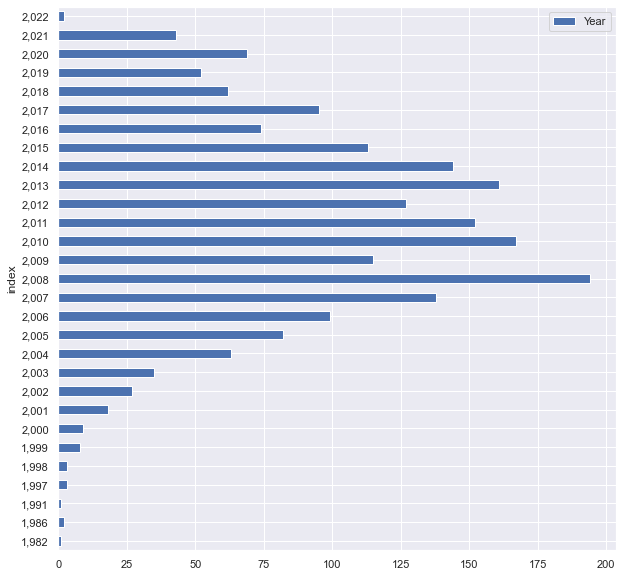

In [15]:
test_data.Year.value_counts().reset_index().sort_values('index').set_index('index').plot(kind = 'barh',figsize=(10,10))

## some of the duplicated vehicleID, let's see if there's a difference with other columns

In [16]:
data.VehicleID.value_counts().head()

VHL12352    5
VHL12773    5
VHL17066    5
VHL16443    5
VHL14590    5
Name: VehicleID, dtype: int64

In [17]:
data[data.VehicleID == 'VHL18344']

,VehicleID,Location,Maker,Model,Year,Colour,Amount (Million Naira),Type,Distance
1410,VHL18344,Lagos,Toyota,Camry SE FWD (2.5L 4cyl 8AM),"2,018",Black,11.6,Foreign Used,NaN
2106,VHL18344,Lagos,Toyota,Tacoma 4x4 Access Cab,"2,008",White,6.0,Foreign Used,"145,000"
4729,VHL18344,Lagos,Toyota,4-Runner,"2,000",Silver,3.2,Foreign Used,"80,965"
5059,VHL18344,Lagos,Lexus,LX,"2,021",Gold,95.0,Brand New,"2,000"
6022,VHL18344,Abuja,Toyota,Highlander Limited 4x4,"2,009",Gray,4.5,Nigerian Used,NaN


In [18]:
data[data.VehicleID == 'VHL18344']

,VehicleID,Location,Maker,Model,Year,Colour,Amount (Million Naira),Type,Distance
1410,VHL18344,Lagos,Toyota,Camry SE FWD (2.5L 4cyl 8AM),"2,018",Black,11.6,Foreign Used,NaN
2106,VHL18344,Lagos,Toyota,Tacoma 4x4 Access Cab,"2,008",White,6.0,Foreign Used,"145,000"
4729,VHL18344,Lagos,Toyota,4-Runner,"2,000",Silver,3.2,Foreign Used,"80,965"
5059,VHL18344,Lagos,Lexus,LX,"2,021",Gold,95.0,Brand New,"2,000"
6022,VHL18344,Abuja,Toyota,Highlander Limited 4x4,"2,009",Gray,4.5,Nigerian Used,NaN


In [19]:
data[data.VehicleID == 'VHL14590']

,VehicleID,Location,Maker,Model,Year,Colour,Amount (Million Naira),Type,Distance
583,VHL14590,Abuja,Toyota,FJ Cruiser Base 4x4,"2,008",Blue,4.5,Foreign Used,NaN
982,VHL14590,Ibadan,Nissan,Micra,"2,001",Green,1.4,Foreign Used,"75,000"
2475,VHL14590,Abuja,Mercedes-Benz,E350,"2,010",Silver,6.8,Foreign Used,"85,231"
4300,VHL14590,Lagos,Mercedes-Benz,GL-Class,"2,007",Black,2.5,Nigerian Used,"1,324,810"
6883,VHL14590,Lagos,Lexus,RX 350 F Sport AWD,"2,019",White,23.8,Foreign Used,"4,418"


#### try this aggregation by diff columns if it works for you

#combinations = [['Location','Maker'],['Type','Maker']]
combinations = [['Year']]#,['Model']]
i = 0 
for combination in combinations:
    target = 'Amount (Million Naira)'
    renamed_target =  target + str(i)
    new_cols = combination + [renamed_target]
    temp_data = data.groupby(combination).mean()[target].reset_index()
    temp_data.columns = new_cols
    data = pd.merge(data,temp_data,on = combination,how = 'left')
    test_data = pd.merge(test_data,temp_data,on = combination,how = 'left')
    i+=1                            

In [20]:
data['train']  =1
test_data['train']  =0

## mergeing train asn test for processing

In [21]:
all_data = pd.concat([data.drop('Amount (Million Naira)',axis  =  1),test_data]).reset_index(drop = True)

In [22]:
all_data.head()

,VehicleID,Location,Maker,Model,Year,Colour,Type,Distance,train
0,VHL12546,Abuja,Honda,Accord Coupe EX V-6,"2,011",Silver,Nigerian Used,NaN,1
1,VHL18827,Ibadan,Hyundai,Sonata,"2,012",Silver,Nigerian Used,"125,000",1
2,VHL19499,Lagos,Lexus,RX 350,"2,010",Red,Foreign Used,"110,852",1
3,VHL17991,Abuja,Mercedes-Benz,GLE-Class,"2,017",Blue,Foreign Used,"30,000",1
4,VHL12170,Ibadan,Toyota,Highlander,"2,002",Red,Nigerian Used,"125,206",1


## creating a character count vectorizer for the merged string of these columns: 'Year', 'Maker', 'Model', 'Colour', 'Type'


In [23]:
##before
all_data[['Year', 'Maker', 'Model', 'Colour', 'Type']].head(1)

,Year,Maker,Model,Colour,Type
0,"2,011",Honda,Accord Coupe EX V-6,Silver,Nigerian Used


In [24]:
##after
''.join(all_data[['Year', 'Maker', 'Model', 'Colour', 'Type']].astype(str).iloc[0].values)

'2,011HondaAccord Coupe EX V-6SilverNigerian Used'

In [25]:
mashup = [''.join(all_data[['Year', 'Maker', 'Model', 'Colour', 'Type']].astype(str).iloc[i].values) for i in range(len(all_data))]
### 
mashup_cleaned = [mashup[i].strip().replace(',','') for i in range(len(mashup))]

Vectorizer= CountVectorizer(
                analyzer = "char",  
                tokenizer = None,  
                preprocessor = None, 
                stop_words = None,  
                max_features = 5000,
)
Vectorizer.fit(mashup_cleaned)
letter_array = Vectorizer.transform(mashup_cleaned).toarray()
vocab = Vectorizer.vocabulary_
letter_data = pd.DataFrame(letter_array,columns=vocab)

In [26]:
letter_data.head()

,2,0,1,h,o,n,d,a,c,r,...,4,.,8,+,(,),q,j,/,&
0,4,0,0,0,0,1,0,0,1,2,...,0,3,2,0,2,2,0,1,0,0
1,1,0,0,0,0,0,0,0,1,1,...,0,2,3,1,2,1,0,0,1,0
2,2,0,0,0,0,0,0,0,3,1,...,0,3,2,0,2,0,0,2,0,0
3,1,0,0,0,0,2,0,0,1,1,...,0,2,4,0,2,0,0,0,0,1
4,1,0,0,0,0,0,0,0,2,0,...,0,3,1,2,1,0,0,0,1,0


In [27]:
cat_col = ['Location', 'Maker', 'Model', 'Year', 'Colour', 'Type']

### Label encoder for the categorical columns

In [28]:
for col in cat_col:
    lab = LabelEncoder()#CountEncoder(normalize=True)
    lab.fit(all_data[col])
    all_data[col] = lab.transform(all_data[col])

In [29]:
all_data.head()

,VehicleID,Location,Maker,Model,Year,Colour,Type,Distance,train
0,VHL12546,0,17,141,23,18,2,NaN,1
1,VHL18827,1,19,1202,24,18,2,"125,000",1
2,VHL19499,2,29,1038,22,17,1,"110,852",1
3,VHL17991,0,34,588,29,3,1,"30,000",1
4,VHL12170,1,53,657,14,17,2,"125,206",1


all_data.VehicleID = all_data.VehicleID.apply(lambda x : int(x[3:]))

## dropping columns to improce accuracy

In [31]:
all_data = all_data.drop(['VehicleID','Distance','Location'],axis = 1)

## merging the Label encoded data and the character count data

In [32]:
all_data = pd.concat([all_data,letter_data],axis = 1)

## splitting into train and test after processing

In [33]:
train_set = all_data[all_data.train == 1]
test_set = all_data[all_data.train == 0]

In [34]:
train_set =  train_set.drop('train',axis = 1)
test_set =  test_set.drop('train',axis = 1)

In [35]:
train_set.head()

,Maker,Model,Year,Colour,Type,2,0,1,h,o,...,4,.,8,+,(,),q,j,/,&
0,17,141,23,18,2,4,0,0,0,0,...,0,3,2,0,2,2,0,1,0,0
1,19,1202,24,18,2,1,0,0,0,0,...,0,2,3,1,2,1,0,0,1,0
2,29,1038,22,17,1,2,0,0,0,0,...,0,3,2,0,2,0,0,2,0,0
3,34,588,29,3,1,1,0,0,0,0,...,0,2,4,0,2,0,0,0,0,1
4,53,657,14,17,2,1,0,0,0,0,...,0,3,1,2,1,0,0,0,1,0


In [36]:
test_set.head()

,Maker,Model,Year,Colour,Type,2,0,1,h,o,...,4,.,8,+,(,),q,j,/,&
7188,3,27,20,22,1,1,0,0,0,0,...,0,1,1,1,1,0,2,0,0,0
7189,53,316,25,22,1,1,0,0,0,0,...,0,2,1,3,1,0,1,0,2,0
7190,53,672,17,8,1,3,0,0,0,0,...,0,2,1,3,1,1,0,0,1,0
7191,53,316,23,9,1,1,0,0,0,0,...,0,3,1,2,1,0,0,0,3,0
7192,29,483,25,17,1,3,0,0,0,0,...,0,2,3,0,2,0,1,1,0,0


# splittng the data

In [37]:
X = train_set
y = target_col
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [48]:
r1 = XGBRegressor(random_state = 42)
r2 = RandomForestRegressor(random_state=42)
r3 = CatBoostRegressor(verbose=False,random_state = 42)


### training on all data ::: not advisable due to overfitting

In [56]:
model = VotingRegressor([('r1', r1),('rf', r2),('r3',r3)],weights=(1,1,1))
model.fit(X,y)
val_pred = model.predict(X_test)
np.mean(mean_squared_error(y_test,val_pred))

13.504449492731641

In [57]:
test =  test_set
test_pred =  model.predict(test)

In [58]:
sub['Amount (Million Naira)'] = test_pred
sub.to_csv('_herolevel.csv',index =  False)

#### 5.63267719862 on public LB

### further ideas

1. cross validation to avoid overfitting
2. fix skewed target
3. segment target and build a model for each segment
4. try different encoding for categorical data
5. try a different vectorizer apart from count vectorizer

### do give a star to the repo if you like this notebook

connect : https://www.linkedin.com/in/abdulqadri-afolabi-6b095b13b/